""" Explore Population files and re-allocate population to grid.
It can also be used to visualize static grids and create dummy emissions/mortality files
 @author: lucarojasmendoza last modified: 2024-02-12 """

In [ ]:
#import packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box
from shapely.geometry import Point
from datetime import datetime
import os
from time import time
from cmcrameri import cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import random as random
import xarray as xr

# Import supporting functions 
%run sgrids.py

# Visualize Demographics Data

In [ ]:
pop_gdf= gpd.read_file('Pavitra_IITB/Population/GPW_Ind_2020_1km_LLC.shp')

In [ ]:
pop_gdf.head(20)

In [ ]:
pop_gdf.shape

In [ ]:
pop_gdf.iloc[0:500].plot(facecolor='none',edgecolor='black')

In [ ]:
random.seed(42)  # Setting seed for reproducibility
random_indices = random.sample(range(len(pop_gdf)), 50000)
random_sample = pop_gdf.iloc[random_indices]
random_sample.plot(facecolor='none', edgecolor='black')

In [ ]:
pop_gdf['TotalPop'].sum()

In [ ]:
pop_gdf.crs

## Static grid resolution algorithm (https://inmap.run/docs/variable_grid/)
The static algorithm chooses the size of all grid cells before the simulation starts, and does not change the size of any grid cells while the simulation is running. Grid cell sizes are chosen based on the number of people in the grid cell, where any grid cell with more people than specified by the VarGrid.PopThreshold configuration variable or containing any region with population density greater than specified by the VarGrid.PopDensityThreshold configuration variable (in units of people per the square of the native length units of the grid [e.g., meters or degrees]) is split into smaller grid cells. This algorithm is applied to all grid cells within the number of vertical layers from ground-level specified by the VarGrid.HiResLayers configuration variable. All grid cells above that layer are kept at the lowest possible resolution.

To choose this algorithm, users can set the static configuration variable to true. The static grid must either be created ahead of time using the inmap grid command or at the beginning of the simulation by setting the creategrid configuration variable to true.

In [5]:
source_crs="+proj=merc +units=m +a=6370000.0 +b=6370000.0 +lon_0=80.0 +lat_ts=15.0 +no_defs"
pop_gdf.crs=source_crs
dems = pop_gdf.copy()

NameError: name 'pop_gdf' is not defined

In [6]:
#Map of India and SAARC
india_gdf = gpd.read_file('Pavitra_IITB/INDIA_BOUNDARY/INDIA_BOUNDARY.shp')
saarcwi_gdf = gpd.read_file('Pavitra_IITB/INDIA_BOUNDARY/SAARCWIC.shp')
india_gdf= india_gdf.to_crs(source_crs)
saarcwi_gdf=saarcwi_gdf.to_crs(source_crs)

In [7]:
#Example 27 km Grid Cell Only (Does not match grid cells of WRF-CHEM Domain)
VariableGridXo=-2298000.274
VariableGridYo= -202000.500
VariableGridDxy= 60000
Xnests=[75,2,2,3]
Ynests=[81,2,2,3]
#Threshold values for TotalPop and density
totalpop_threshold = 200000
density_threshold = 0.02

In [ ]:
#Visualize demographics 
visualize_data(dems, source_crs, VariableGridXo, VariableGridYo, VariableGridDxy, Xnests, Ynests)

In [ ]:
gdf=sgrids(dems, source_crs,
           VariableGridXo, VariableGridYo, VariableGridDxy, 
           Xnests, Ynests,
           totalpop_threshold,density_threshold, plots=False)

In [ ]:
#Save file
gdf=gpd.read_file('60000_2_2_3_200000_02.shp')

In [32]:
gdf.crs=source_crs

In [8]:
gdf['TotalPop'].sum()

1411594183.0698652

In [14]:
gdf[gdf['length']==15000]

,index,TotalPop,density,area,length,geometry
1584,1584,54911.946291,0.000422,225000000.0,15000.0,"POLYGON ((-1113000.274 2377999.500, -1128000.2..."
1585,1585,86574.105090,0.000421,225000000.0,15000.0,"POLYGON ((-1113000.274 2392999.500, -1128000.2..."
1586,1586,44320.611458,0.000422,225000000.0,15000.0,"POLYGON ((-1098000.274 2377999.500, -1113000.2..."
1587,1587,43208.126590,0.000420,225000000.0,15000.0,"POLYGON ((-1098000.274 2392999.500, -1113000.2..."
1588,1588,58584.841692,0.000420,225000000.0,15000.0,"POLYGON ((-1113000.274 2407999.500, -1128000.2..."
...,...,...,...,...,...,...
26660,26660,62170.294702,0.000454,225000000.0,15000.0,"POLYGON ((1691999.726 3052999.500, 1676999.726..."
26661,26661,104070.250657,0.000483,225000000.0,15000.0,"POLYGON ((1676999.726 3067999.500, 1661999.726..."
26662,26662,107052.145430,0.000482,225000000.0,15000.0,"POLYGON ((1676999.726 3082999.500, 1661999.726..."
26663,26663,85419.486419,0.000483,225000000.0,15000.0,"POLYGON ((1691999.726 3067999.500, 1676999.726..."


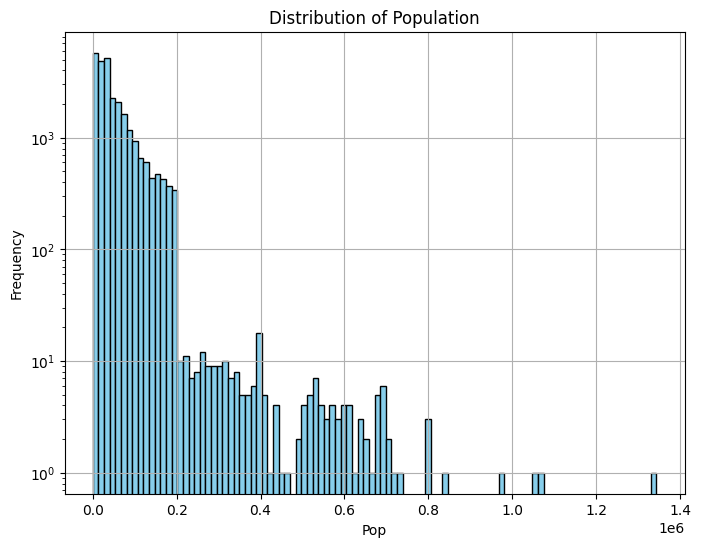

In [15]:
# Plot frequency bar plot of 'density' column with log scale
plt.figure(figsize=(8, 6))
plt.hist(gdf['TotalPop'], bins=100, color='skyblue', edgecolor='black')
plt.yscale('log')  # Set y-axis to log scale
plt.title('Distribution of Population')
plt.xlabel('Pop')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

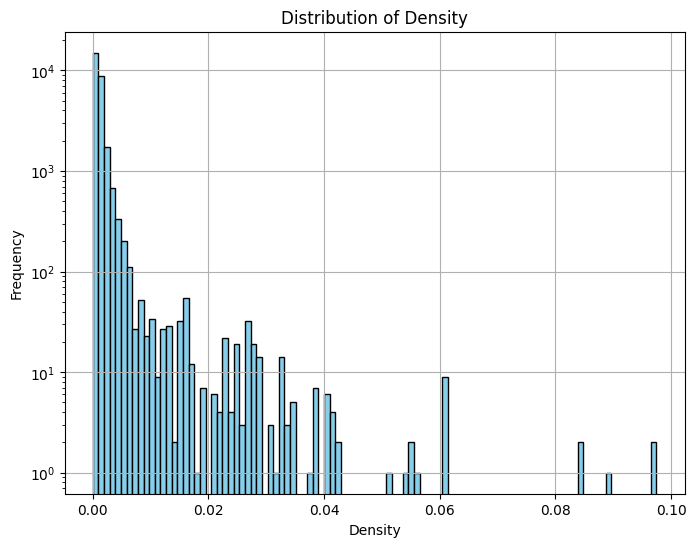

In [16]:
# Plot frequency bar plot of 'density' column with log scale
plt.figure(figsize=(8, 6))
plt.hist(gdf['density'], bins=100, color='skyblue', edgecolor='black')
plt.yscale('log')  # Set y-axis to log scale
plt.title('Distribution of Density')
plt.xlabel('Density')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<Axes: title={'center': 'Population Density using 60,30,15, 5Km grids in (# / m²)'}>

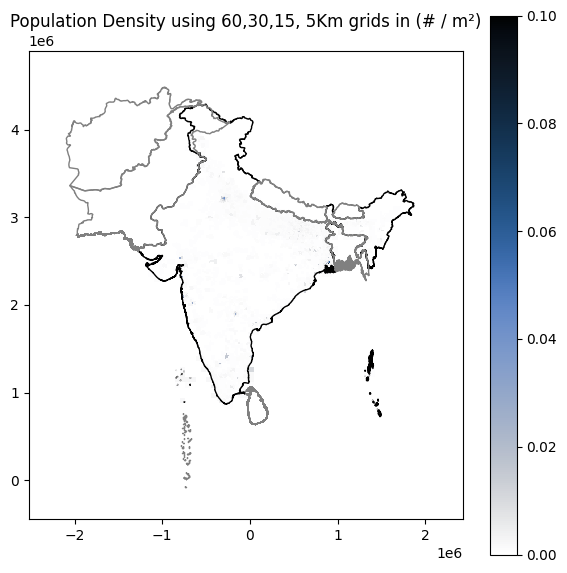

In [17]:
# Plot the population redistribution
fig, ax = plt.subplots(figsize=(7, 7))
gdf.plot(column='density', cmap=cm.oslo_r, legend=True, ax=ax, vmin=0, vmax=0.1)
plt.title('Population Density using 60,30,15, 5Km grids in (# / m\u00B2)')

# Plot the map of India on the same plot
india_gdf.plot(ax=ax, color='none', edgecolor='black')
saarcwi_gdf.plot(ax=plt.gca(), color='none', edgecolor='gray')

In [18]:
#Modify for india states or map of other communities of interest
india_gdf = gpd.read_file('Pavitra_IITB/INDIA_BOUNDARY/INDIA_BOUNDARY.shp').to_crs(source_crs)
saarcwi_gdf = gpd.read_file('Pavitra_IITB/INDIA_BOUNDARY/SAARCWIC.shp').to_crs(source_crs)
state_gdf=gpd.read_file('Pavitra_IITB/INDIA_BOUNDARY/India_State_Boundary.shp').to_crs(source_crs)
district_gdf=gpd.read_file('Pavitra_IITB/INDIA_BOUNDARY/India_District_Merge.shp').to_crs(source_crs)
city_gdf=gpd.read_file('Pavitra_IITB/INDIA_BOUNDARY/cities.shp').to_crs(source_crs)

india_gdf = india_gdf[['OBJECTID', 'geometry']]
state_gdf = state_gdf[['Name', 'geometry']]
district_gdf = district_gdf[['dtname','stname','geometry']]
city_gdf = city_gdf[['Name','geometry']]
saarcwi_gdf = saarcwi_gdf[['NAME_0','geometry']]

In [19]:
sgrids_table(gdf)

,Number of grids
60000.0,5149
30000.0,1396
15000.0,7783
5000.0,13041
totals,27369


In [20]:
np.sum(gdf['TotalPop']*gdf['length'])/(gdf['TotalPop'].sum())

13395.3026443011

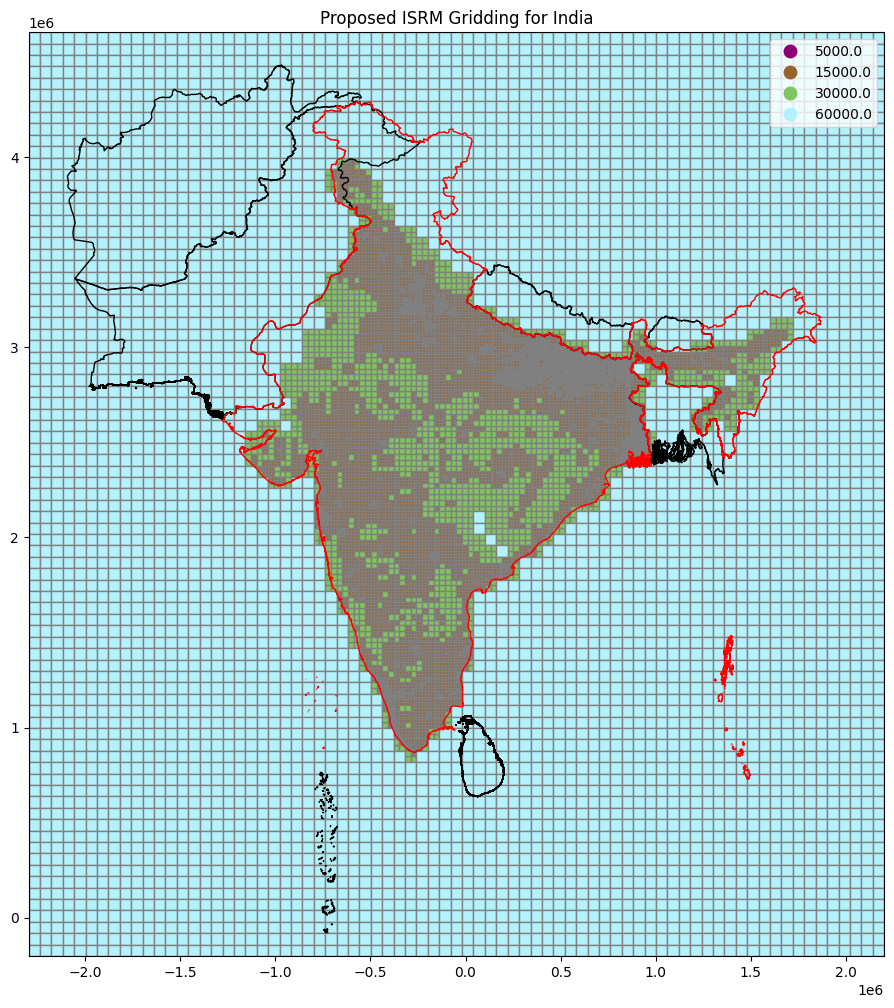

In [21]:
plot_with_scalebar(gdf, saarcwi_gdf, india_gdf, VariableGridXo,VariableGridYo,VariableGridDxy, x=Xnests[0],
                       y=Ynests[0], figsize=(12, 12), target_crs=source_crs, title='Proposed ISRM Gridding for India')

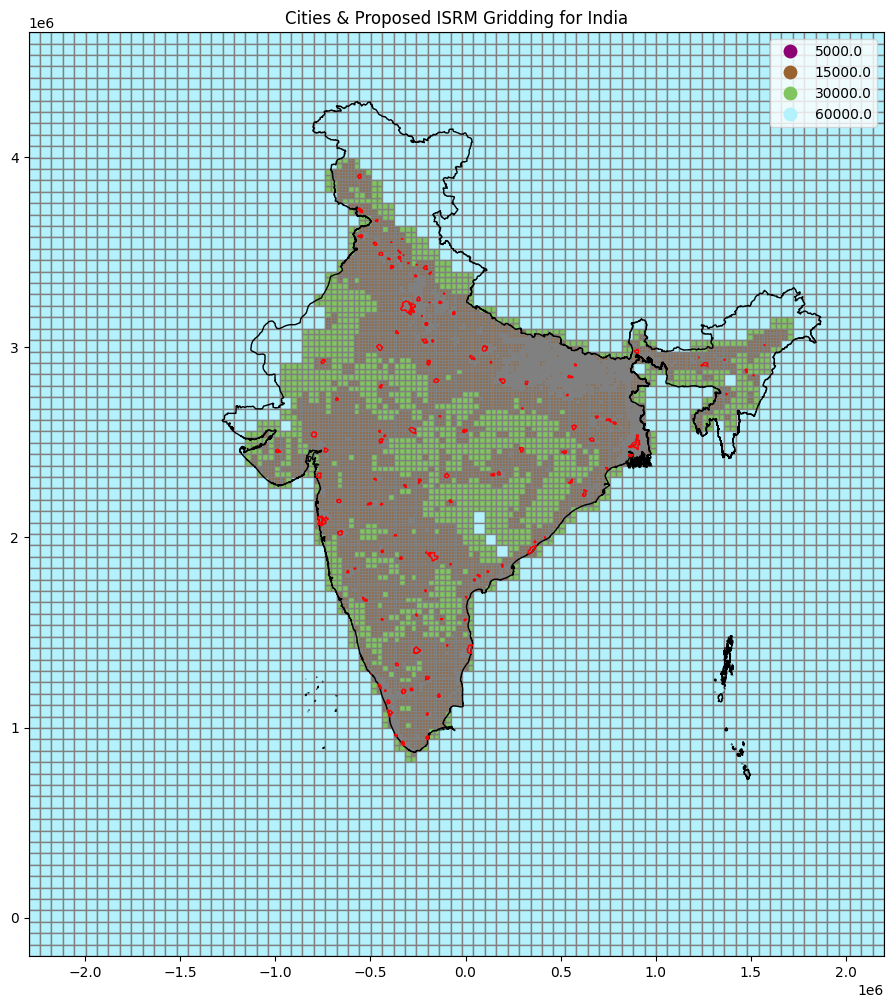

In [22]:
plot_with_scalebar(gdf, india_gdf, city_gdf, VariableGridXo,VariableGridYo,VariableGridDxy, x=Xnests[0],
                       y=Ynests[0], figsize=(12, 12), target_crs=source_crs, title='Cities & Proposed ISRM Gridding for India')

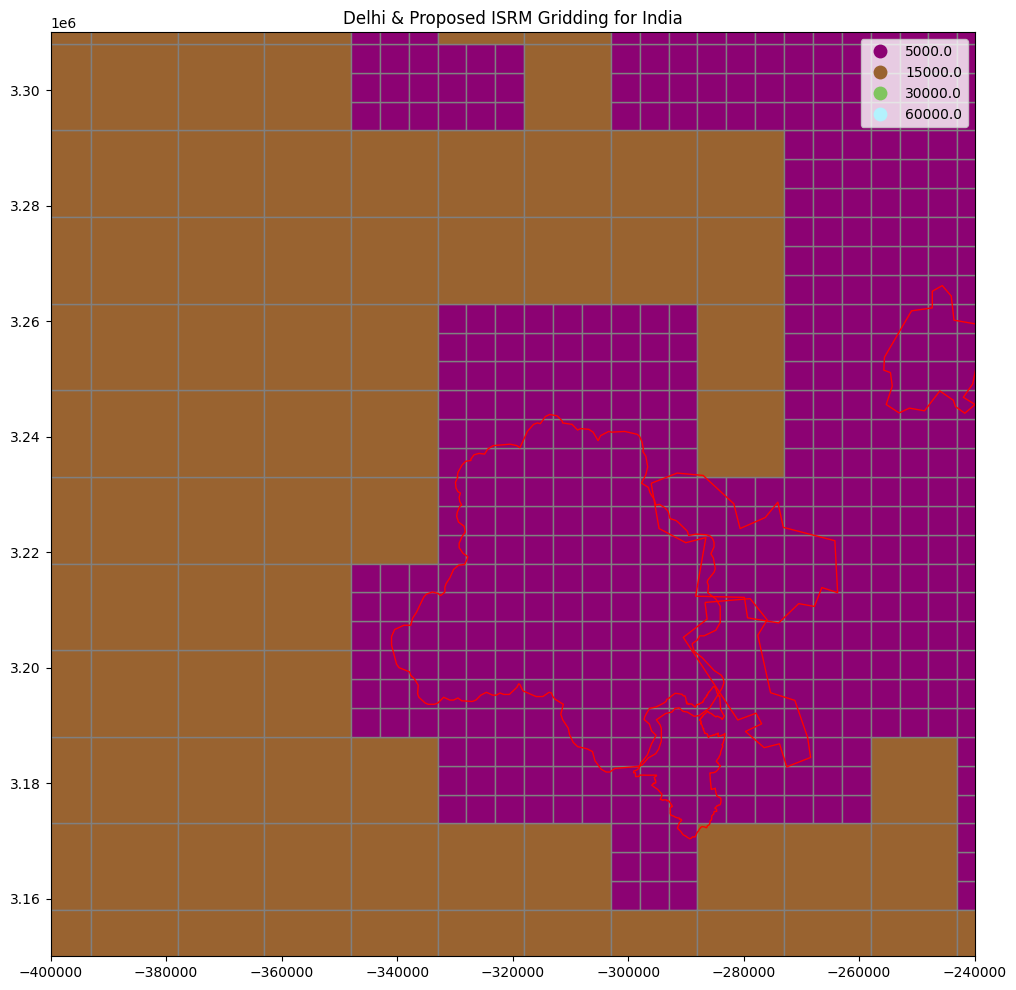

In [23]:
plot_with_scalebar(gdf, india_gdf, city_gdf, -400000,3150000,160000, 1,
                       y=1, figsize=(12, 12), target_crs=source_crs, title='Delhi & Proposed ISRM Gridding for India')

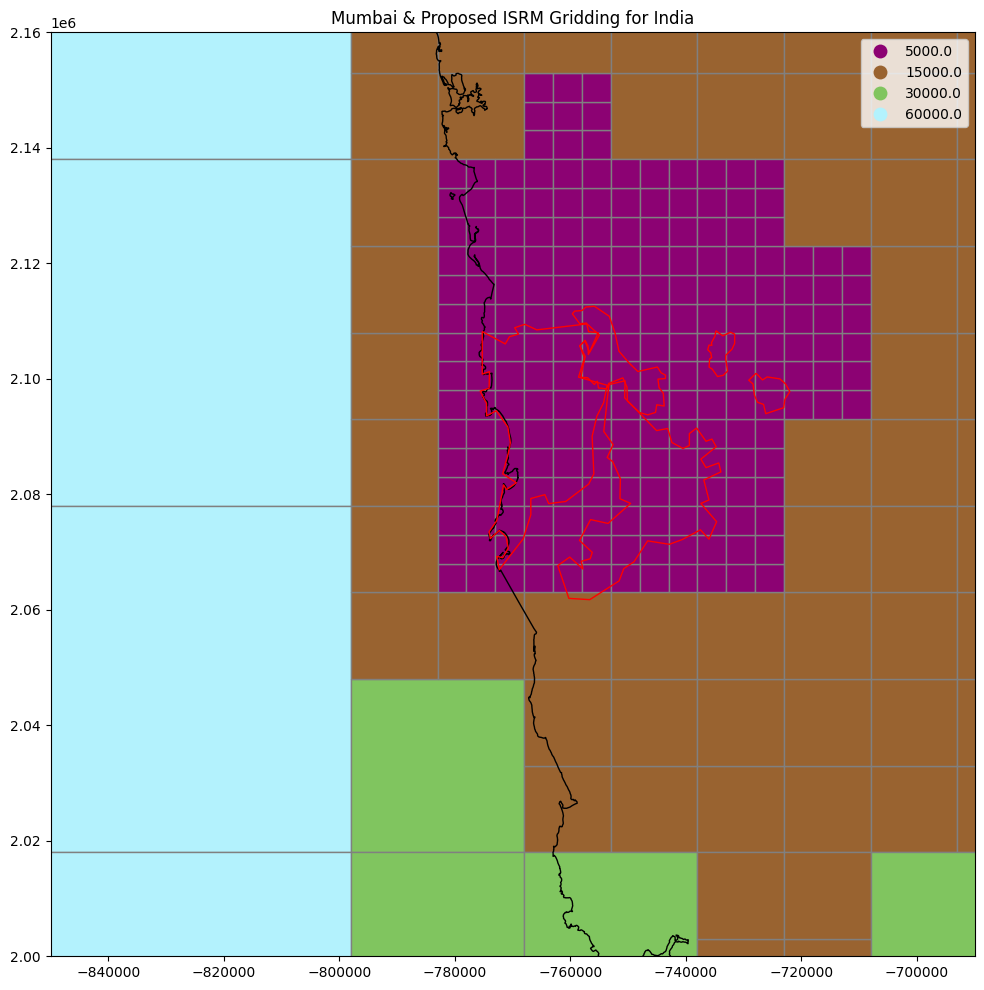

In [24]:
plot_with_scalebar(gdf, india_gdf, city_gdf, -850000,2000000,160000, 1,
                       y=1, figsize=(12, 12), target_crs=source_crs, title='Mumbai & Proposed ISRM Gridding for India')

In [33]:
summary_table=create_summary_table(gdf, city_gdf,index="Name")
desired_cities = ["Delhi", "Mumbai", "Bengaluru", "chennai", "Hyderabad", "Kolkata", "Ahmedabad", "Pune"]
summary_table[summary_table['Name'].isin(desired_cities)]

,Name,PopAveLengthScale,5000.0,15000.0,30000.0,60000.0,Total Cells
1,Ahmedabad,5147.6,32,1,0,0,33
16,Bengaluru,5149.5,40,1,0,0,41
26,Delhi,5000.0,115,0,0,0,115
43,Hyderabad,5438.1,58,3,0,0,61
60,Kolkata,5000.0,78,0,0,0,78
70,Mumbai,5000.0,39,0,0,0,39
86,Pune,5000.0,27,0,0,0,27
113,chennai,5185.5,41,2,0,0,43


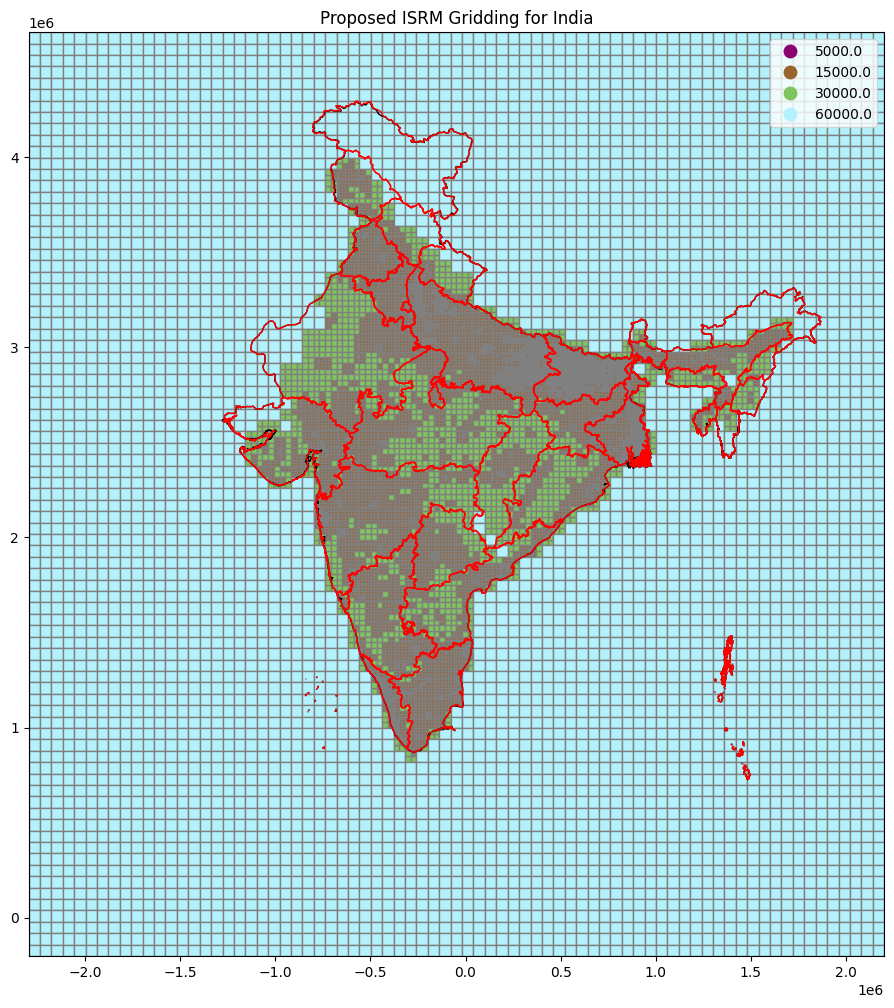

In [26]:
plot_with_scalebar(gdf, india_gdf, state_gdf, VariableGridXo,VariableGridYo,VariableGridDxy, x=Xnests[0],
                       y=Ynests[0], figsize=(12, 12), target_crs=source_crs, title='Proposed ISRM Gridding for India')

In [35]:
create_summary_table(gdf, state_gdf[state_gdf['Name']=='Delhi'],index="Name")

,Name,PopAveLengthScale,5000.0,Total Cells
0,Delhi,5000.0,100,100


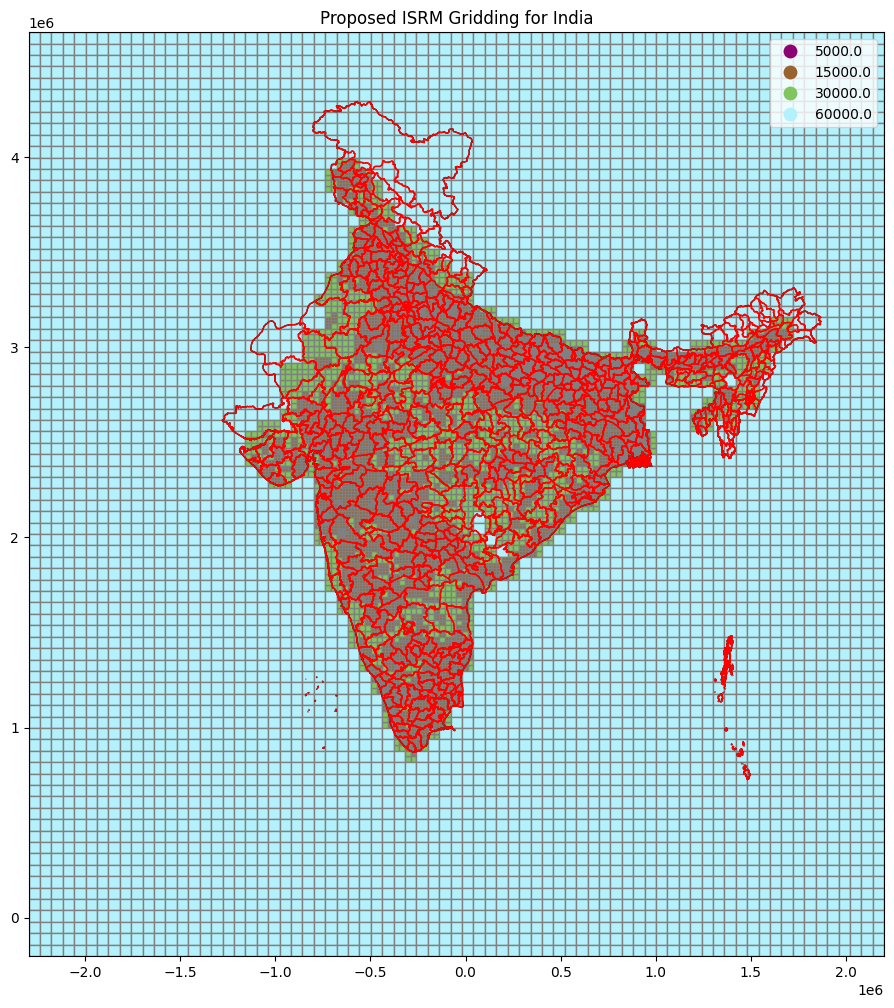

In [28]:
plot_with_scalebar(gdf, india_gdf, district_gdf, VariableGridXo,VariableGridYo,VariableGridDxy, x=Xnests[0],
                       y=Ynests[0], figsize=(12, 12), target_crs=source_crs, title='Proposed ISRM Gridding for India')

In [30]:
create_summary_table(gdf, district_gdf[district_gdf['dtname']=='Kupwara'],index="dtname")

/Users/lrojasm/Desktop/PyCharmProjects/PavitraProject/sgrids.py:269: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: PROJCS["unknown",GEOGCS["GCS_unknown",DATUM["D_unk ...
Right CRS: +proj=merc +units=m +a=6370000.0 +b=6370000.0 +lon ...

  overlay_gdf = gpd.overlay(grid_gdf, community_gdf, how='intersection')


,dtname,PopAveLengthScale,15000.0,30000.0,Total Cells
0,Kupwara,17985.1,20,5,25


# Create Dummy Emission file

In [ ]:
# Could define points Mannually
# Define the list of points
points = [
    (77.1025, 28.7041),
    (72.8777, 19.0760)]


# Create a list of Point geometries
geometries = [Point(x, y) for x, y in points]

# Create a GeoPandas DataFrame
gdf = gpd.GeoDataFrame(geometry=geometries)

# create a new dataframe with only the geometry column
Emissions = gdf[['geometry']].copy()

# add the new columns to the Emissions dataframe with default values
cols = {'VOC': 1, 'NOx': 1, 'NH3': 1, 'SOx': 1, 'PM2_5': 1, 'height': 0, 'diam': 0, 'temp': 0, 'velocity': 0}
Emissions = Emissions.assign(**cols)

# Convert polygon geometries to point geometries at the center of the polygons
Emissions['geometry'] = Emissions['geometry'].centroid

# Reorder the columns and move the geometry column to the last
Emissions = Emissions[['VOC', 'NOx', 'NH3', 'SOx', 'PM2_5', 'height', 'diam', 'temp', 'velocity', 'geometry']]

Emissions.crs = 'EPSG:4326' 


In [ ]:
#Could also read grid of interest
gdf=gpd.read_file('.....')

# create a new dataframe with only the geometry column
Emissions_2 = gdf[['geometry']].copy()

# add the new columns to the Emissions dataframe with default values
cols = {'VOC': 10, 'NOx': 10, 'NH3': 10, 'SOx': 10, 'PM2_5': 10, 'height': 0, 'diam': 0, 'temp': 0, 'velocity': 0}
Emissions_2 = Emissions_2.assign(**cols)

# Convert polygon geometries to point geometries at the center of the polygons
Emissions_2['geometry'] = Emissions_2['geometry'].centroid

# Reorder the columns and move the geometry column to the last
Emissions_2 = Emissions_2[['VOC', 'NOx', 'NH3', 'SOx', 'PM2_5', 'height', 'diam', 'temp', 'velocity', 'geometry']]
